# Praca domowa 3

In [1]:
import pandas as pd
import numpy as np

data = pd.read_stata("hcmst.dta")

In [2]:
data.head(3)

,CaseID,CASEID_NEW,qflag,weight1,weight1_freqwt,weight2,weight1a,weight1a_freqwt,weight_combo,weight_combo_freqwt,...,hcm2017q24_met_through_family,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
0,2,2014039,Qualified,NaN,NaN,0.8945,NaN,NaN,0.277188,19240.0,...,no,no,no,no,White,no,12.0,14.0,12.0,14.0
1,3,2019003,Qualified,0.9078,71115.0,NaN,0.9026,70707.0,1.020621,70841.0,...,no,no,no,yes,White,no,12.0,16.0,17.0,17.0
2,5,2145527,Qualified,0.7205,56442.0,NaN,0.7164,56121.0,0.810074,56227.0,...,no,no,no,no,White,no,9.0,7.5,14.0,17.0


# Wybranie cech:

In [3]:
num1 = "Q34"             # Ocena jakości związku
num2 = "ppeduc"          # Najwyzszy zdobyty poziom edukacji
num3 = "Q9"              # Wiek partnera
cat1 = "Q19"             # Czy mieszkacie ze sobą obecnie?
cat2 = "Q12"             # Polityczne preferencje partnera
label = "S1"             # Czy jesteście małżeństwem

data = data[[num1,num2,cat1,cat2,num3,label]].dropna()
data.rename(columns={'Q9':'partners_age','Q34':'rel_quality','ppeduc':'education','Q19':'living_together','Q12':'partner_politics'}, inplace=True)
data.head()

,rel_quality,education,living_together,partner_politics,partners_age,S1
1,Excellent,Masters degree,Yes,Leans Republican,52,"Yes, I am Married"
2,Good,Masters degree,Yes,Leans Democrat,45,"Yes, I am Married"
4,Excellent,Bachelors degree,Yes,Strong Democrat,59,"Yes, I am Married"
5,Good,HIGH SCHOOL GRADUATE - high school DIPLOMA or ...,Yes,Undecided/Independent/Other,60,"Yes, I am Married"
6,Excellent,HIGH SCHOOL GRADUATE - high school DIPLOMA or ...,Yes,Leans Republican,67,"Yes, I am Married"


In [4]:
data.describe()

,rel_quality,education,living_together,partner_politics,partners_age,S1
count,2856,2856,2856,2856,2856.0,2856
unique,6,14,3,8,79.0,2
top,Excellent,HIGH SCHOOL GRADUATE - high school DIPLOMA or ...,Yes,Undecided/Independent/Other,55.0,"Yes, I am Married"
freq,1706,723,2387,823,79.0,2079


In [5]:
from sklearn import preprocessing
    
le = preprocessing.LabelEncoder()

for column_name in data.columns:
    if column_name == "rel_quality":
        data[column_name] = data[column_name].map({
            'Refused':-1, 
            'Excellent':5, 
            "Good":4, 
            "Fair":3, 
            "Poor":2, 
            "Very poor":1
        })
    
    if column_name == "education":
        data[column_name] = data[column_name].map({
            'No formal education':1, 
            '1st, 2nd, 3rd, or 4th grade':2, 
            '5th or 6th grade':3,
            '7th or 8th grade':4,
            '9th grade':5,
            '10th grade':6,        
            '11th grade':7, 
            '12th grade no diploma':8,
            'HIGH SCHOOL GRADUATE - high school DIPLOMA or the equivalent (GED)':9,
            'Some college, no degree':10,
            'Bachelors degree':11,
            'Masters degree':12,
            'Associate degree':13,
            'Professional or Doctorate degree':14
        })
        
    if column_name == 'partner_politics':
         data[column_name] = data[column_name].map({
            'Strong Republican' :1,
            'Not Strong Republican' :2,
            'Leans Republican' :3,
            'Undecided/Independent/Other' :4,
            'Leans Democrat' :5,
            'Not Strong Democrat' :6,   
            'Strong Democrat' :7
           })
    
    if column_name == 'living_together':
         data[column_name] = data[column_name].map({
            'Refused' :-1,
            'Yes' :1,
            'No' :2
         })
            
    if column_name != 'rel_quality' and column_name != 'education' and column_name != 'partner_politics' and column_name != 'living_together' and hasattr(pd.Series(data[column_name], dtype='category'), 'cat'):
        data[column_name] = le.fit_transform(data[column_name].astype(str))
             
    else:
        pass

# Podział zbioru danych na treningowy i testowy:

In [6]:
from sklearn.model_selection import train_test_split

data = data.dropna()

y = data.loc[:,'S1']
X = data.loc[:, data.columns != 'S1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1851, 5), (912, 5), (1851,), (912,))

# Model:

In [7]:
#from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

random_forest = RandomForestClassifier(n_estimators=100, max_depth=3,random_state=25)

y_pred = random_forest.fit(X_train,y_train).predict(X_test)
acc = accuracy_score(y_test,y_pred)
print("Model accuracy score: " + str(acc))

Model accuracy score: 0.8629385964912281


# Wykres Break Down:

In [114]:
import waterfall_chart

def f(data, model, sample, feature_list):
    
    X_temp = data.copy()
    probabilities = []
    deltas = []

    # obliczenie sredniej odpowiedzi dla calego zbioru:
    temp_results = []
    
    for k in range(len(X_temp)):
        prob_single_sample = model.predict_proba(X_temp.iloc[[k]])
        temp_results.append(prob_single_sample[0][1])
        
    mean_prob = np.mean(temp_results)
    probabilities.append(mean_prob)
    deltas.append(probabilities[0])
    
    # obliczanie sredniej odpowiedzi dla ustalonych kolejnych zmiennych:
    
    for i in range(len(feature_list)):
        X_temp.loc[:,feature_list[i]] = int(sample[feature_list[i]]) 
        temp_results = []
        
        for j in range(len(X_temp)):
            prob_single_sample = model.predict_proba(X_temp.iloc[[j]])
            temp_results.append(prob_single_sample[0][1])
        
        mean_prob = np.mean(temp_results)
        probabilities.append(mean_prob)
        
        deltas.append(probabilities[i+1]-probabilities[i])
    
    waterfall_chart.plot(['base'] + feature_list, deltas, Title = "Models mean response",
                         net_label='End result', formatting='{:,.2f}')

    return

# Przykłady zastosowania na konkretnych próbkach:

In [161]:
single_couple = X_train.sample()
single_couple

,rel_quality,education,living_together,partner_politics,partners_age
1059,5.0,12.0,2,5.0,18


In [162]:
# sprawdzenie, jaka jest odpowiedź dla danej próbki w zbiorze danych

data.loc[single_couple.iloc[0].name].reset_index()

,index,1059
0,rel_quality,5.0
1,education,12.0
2,living_together,2.0
3,partner_politics,5.0
4,partners_age,18.0
5,S1,0.0


In [163]:
# sprawdzenie, jaka jest odpowiedź modelu dla danej próbki

prob_single_sample = random_forest.predict_proba(single_couple)
prob_single_sample[0][1]

0.2197809097250436

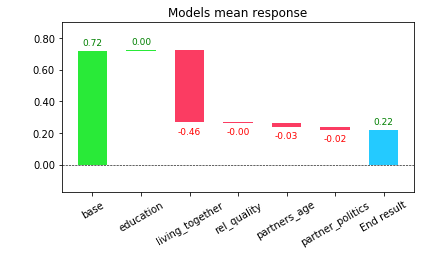

In [164]:
f(X_train,random_forest,single_couple, ["education","living_together","rel_quality","partners_age","partner_politics"])

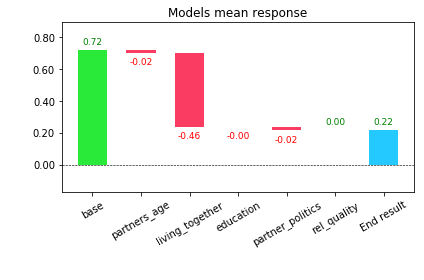

In [165]:
# zmiana kolejnosci zmiennych

f(X_train,random_forest,single_couple, ["partners_age","living_together","education","partner_politics","rel_quality"])

----------------------------------------------------

In [116]:
single_couple = X_train.sample()
single_couple

,rel_quality,education,living_together,partner_politics,partners_age
306,5.0,10.0,1,1.0,53


In [169]:
data.loc[single_couple.iloc[0].name].reset_index()

,index,306
0,rel_quality,5.0
1,education,10.0
2,living_together,1.0
3,partner_politics,1.0
4,partners_age,53.0
5,S1,1.0


In [170]:
prob_single_sample = random_forest.predict_proba(single_couple)
prob_single_sample[0][1]

0.9118654385293558

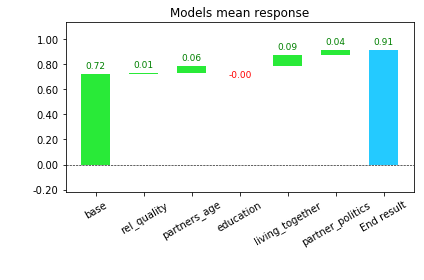

In [119]:
f(X_train,random_forest,single_couple, ["rel_quality","partners_age","education","living_together","partner_politics"])

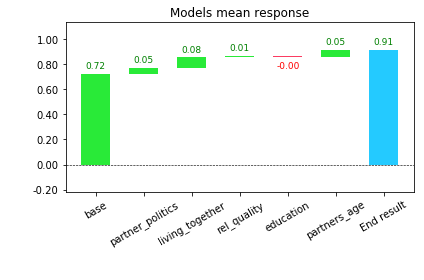

In [171]:
f(X_train,random_forest,single_couple, ["partner_politics","living_together","rel_quality","education","partners_age"])

----------------------------------

In [125]:
single_couple = X_train.sample()
single_couple

,rel_quality,education,living_together,partner_politics,partners_age
1922,5.0,13.0,1,7.0,33


In [126]:
data.loc[single_couple.iloc[0].name].reset_index()

,index,1922
0,rel_quality,5.0
1,education,13.0
2,living_together,1.0
3,partner_politics,7.0
4,partners_age,33.0
5,S1,1.0


In [127]:
prob_single_sample = random_forest.predict_proba(single_couple)
prob_single_sample[0][1]

0.8334057168603363

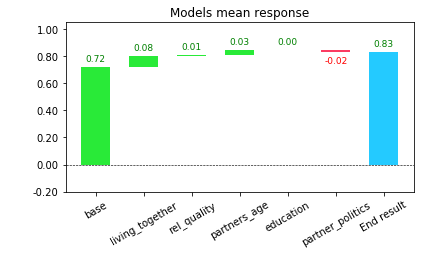

In [128]:
f(X_train,random_forest,single_couple, ["living_together","rel_quality","partners_age","education","partner_politics"])

# Wnioski

* Największy wpływ na odpowiedź modelu mają zmienne: *living_together, partners_age* oraz *partner_politics*, jednak ich wpływy są różne pomiędzy różnymi próbkami - największe różnice wprowadzają te sytuacje, które są skrajne lub nietypowe (wiek poniżej 20 lat, niemieszkanie ze sobą silnie sugeruje, że para nie jest małżeństwem)
* Zmiana kolejności zmiennych wywołuje niewielkie różnice w wartościach wpływów kolejnych zmiennych, ale wnioski, które można wyciągnąć z wykresów dla tej samej próbki z różną kolejnością zmiennych pozostają takie same bez względu na kolejność zmiennych 
* Wyniki pasują do poprzednich wyników: wykresy M-plot dla zmiennej 'education' sugerowały, że nie ma ona specjalnego wpływu na odpowiedź modelu, co tutaj się potwierdziło